# Point Net Homework

The following homework is based on the paper, "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Qi et al.

In this paper, the authors present a novel neural network architecture that takes in point clouds as inputs. This network can be used across many tasks including object segmentation, part segmentation, and scene semantic parsing. 

## 1. 3D Data Representation

There are various ways one could represent 3D before inputting into a neural network. Histocially, networks have used convolutional architecures, which require inputs to be highly standardized. As such, researchers will often convert their data into 3D voxel grids or collections of images. 

As stated by the authors, these data formats are volumous, due to data redundancy, and may introduce quantization artifacts. As such, we will be focusing on 3D Meshes and Point Clouds.



In [2]:
import pyvista as pv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from dataset import ShapeNetDataset
#from pytorch_model_summary import summary

In [3]:
teapot_file_path = '../cs182-proj/images/canvas3D-master/teapot.ply'
points_data = pv.read(teapot_file_path)

### 3D Mesh

The 3D Mesh is generated using a set of polygons to represent the structure of the object. It is determined using points with X, Y, Z coordinates. These points are connected to make polygons, most commonly triangles and quads.


In [3]:
points_data.plot(jupyter_backend='panel')

### Point Cloud
Point Clouds are a basic data format in which the points are represented in 3D space, using X, Y, and Z coordinates. 

In [4]:
sphere = pv.Sphere(radius=0.05)
pc = points_data.glyph(scale=False, geom=sphere, orient=False)
pc.plot(cmap='Reds', jupyter_backend='panel')

"\nsphere = pv.Sphere(radius=0.05)\npc = points_data.glyph(scale=False, geom=sphere, orient=False)\npc.plot(cmap='Reds', jupyter_backend='panel')\n"

The authors in the paper chose to use Point Clouds instead of a 3D Mesh. **Looking at the objects, why would they choose to do so?**

Solution: 3D Meshes have additional complexity and combinations that must be carried through, thereby drastically increasing the complexity of the data format. Further, there is likely little value add by including this additional information outside of for visualization purposes.

## 2. The Model Architecture

The archicture of PointNet is as follows:
![plot](images/model.png)

In the paper, the authors used the ModelNet10 dataset and the ModelNet40 dataset. The ModelNet10 dataset has 10 classes of varying objects.

![plot](images/class_detail.png)

However, given the size of the dataset, it is not feasible to train the entire model in the context of this homework. As such, we have modified the dataset to be a binary classification problem: bathtub or table.

In the following sections we will implement pieces of the architecture and see how they impact the downstream performance of the model

In [5]:
n = 10000
num_classes = 2
epochs = 5

trainset = ShapeNetDataset("datasets/ModelNet2", train=True, n=n)
testset = ShapeNetDataset("datasets/ModelNet2", train=False, n=n)

dataset_length = len(trainset)
train_ratio = 0.7
test_ratio = 0.3

train_len = int(dataset_length * train_ratio)
valid_len = dataset_length - train_len

trainset, validset = random_split(trainset, [train_len, valid_len])


In [6]:
def loss_fn(preds, labels, feature_transform, reg=0.0001):
    loss = torch.nn.NLLLoss()
    def feat_loss(A):
        I = torch.eye(64, requires_grad=True).expand(A.size(0), -1, -1)
        AA_T = torch.bmm(A, A.transpose(1, 2))
        return torch.linalg.norm(I - AA_T, ord='fro', dim=(1,2))
    return loss(preds, labels) + reg * torch.mean(feat_loss(feature_transform))

def train(model, trainset, validset, optimizer, epochs=10, batch_size=32, device=torch.device('cpu')):
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []

    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        # Train and get training loss and accuracy
        train_loss, train_num_correct = [], []
        for x, y in tqdm(train_dataloader, unit='batch'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred, feat = model(x)
            loss = loss_fn(pred, y, feat)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_num_correct.append(torch.sum(pred.argmax(1) == y).item())
        train_losses.append(np.mean(train_loss))
        train_accs.append(np.sum(train_num_correct) / len(trainset))

        model.eval()
        # Get validation loss and accuracy
        with torch.no_grad():
            valid_loss, valid_num_correct = [], []
            for x, y in tqdm(valid_dataloader, unit='batch'):
                x, y = x.to(device), y.to(device)
                pred, feat = model(x)
                loss = loss_fn(pred, y, feat)
                valid_loss.append(loss.item())
                valid_num_correct.append(torch.sum(pred.argmax(1) == y).item())
        valid_losses.append(np.mean(valid_loss))
        valid_accs.append(np.sum(valid_num_correct) / len(validset))
        
        #print('Finished Epoch {}\n training loss: {}, validation loss: {} \n training accuracy: {}, validation accuracy: {}'
        #        .format(epoch+1, train_losses[-1], valid_losses[-1], train_accs[-1], valid_accs[-1]))

    return train_losses, valid_losses, train_accs, valid_accs

In [7]:
def plot_charts(train_accs, train_losses, valid_accs, valid_losses):
    
    fig, axs = plt.subplots(2, figsize=(10, 8))
    
    ##################################################
    # TO DO:
    # Please create two charts
    # 1. Plot the train and valid accuracy
    # 2. Plot the train and valid losses
    ##################################################
    
    plt.tight_layout()
    plt.legend()
    plt.show()
    

### 2.1 Baseline Architecture

The first draft of the model will exclude the input transform and the feature transform.

In the following section, please implement the following:
- Complete the SharedMLP Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Complete the forward function for the BaselineClassificationNN




In [8]:
class MLP(nn.Sequential):
    def __init__(self, layer_sizes, dropout=0.7):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        super(MLP, self).__init__(*layers)
            

class SharedMLP(nn.Sequential):
    def __init__(self, layer_sizes):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Conv1d(layer_sizes[i], layer_sizes[i+1], 1))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.ReLU())
        super(SharedMLP, self).__init__(*layers)

In [9]:
class BaselineClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineClassificationNN, self).__init__()
        
        ##################################################
        # TO DO:
        # Update the dimensions for the MLP layers below using the architecture diagram above
        ##################################################
        
        #self.shared_mlp_1 = SharedMLP([...])
        #self.shared_mlp_2 = SharedMLP([...])
        #self.mlp = MLP([...])

    def forward(self, x):

        ##################################################
        # TO DO:
        # Create the forward function
        # For the baseline model, please follow the architecture diagram for the classification network
        # Here, we will skip the Input Transform and the Feature Transform
        # Don't forget about the max pooling layer
        ##################################################

    def predict(self, x):
        return self.forward(x)[0]

In [10]:
baseline_model = BaselineClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
baseline_train_losses, baseline_valid_losses, baseline_train_accs, baseline_valid_accs = train(baseline_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

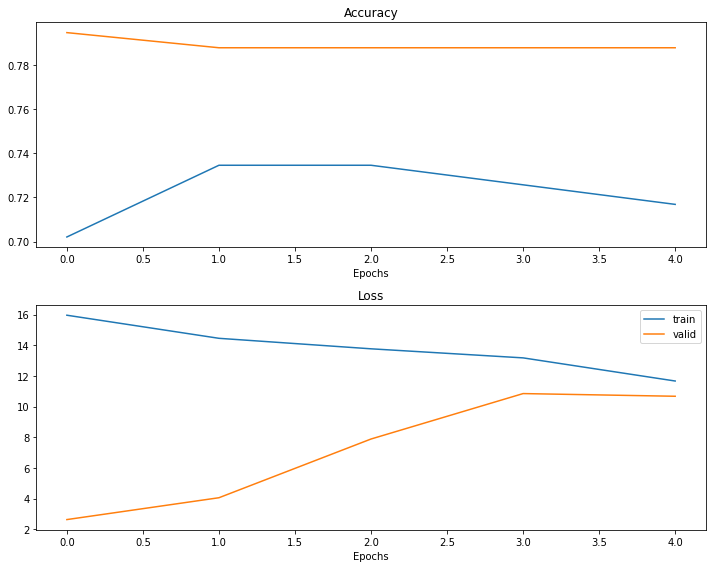

In [11]:
plot_charts(baseline_train_accs, baseline_train_losses, baseline_valid_accs, baseline_valid_losses)

### 2.2 Add Input Transform

In the following section, please implement the following:
- Complete the TNet Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Modify the BaselineClassificationNN to include the Input Transform

In [12]:
class T_net(nn.Module):
    def __init__(self, size, dropout=0.7, bn_momentum=None):
        super(T_net, self).__init__()
        self.size = size

        self.shared_mlp = SharedMLP([size, 64, 128, 1024])

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, size*size, bias=False)
        self.fc3.requires_grad_(False)

        self.bn1 = nn.BatchNorm1d(512, momentum=bn_momentum)
        self.bn2 = nn.BatchNorm1d(256, momentum=bn_momentum)

    def forward(self, x):
        '''
            Input: B x size x N
        '''
        out = self.shared_mlp(x)
        out = F.max_pool1d(out, kernel_size=x.size(-1))
        out = out.view(-1, 1024)
        out = F.relu(self.bn1(self.fc1(out)))
        out = F.relu(self.bn2(self.fc2(out)))

        out = self.fc3(out)
        out = out.view(-1, self.size, self.size)
        bias = torch.eye(self.size, requires_grad=True).expand(x.size(0), -1, -1)
        return out + bias


In [13]:
class InputTransform(nn.Module):
    def __init__(self):
        super(InputTransform, self).__init__()
        self.T_net = T_net(3)

    def forward(self, x):
        out = self.T_net(x)
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)

In [14]:
class InputTransformClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(InputTransformClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):

        ##################################################
        # TO DO:
        # Create the forward function
        # You can copy and paste the code from class above and add the Input Transform
        ##################################################

    def predict(self, x):
        return self.forward(x)[0]

In [15]:
input_transform_model = InputTransformClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(input_transform_model.parameters(), lr=lr)
input_train_losses, input_valid_losses, input_train_accs, input_valid_accs = train(input_transform_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

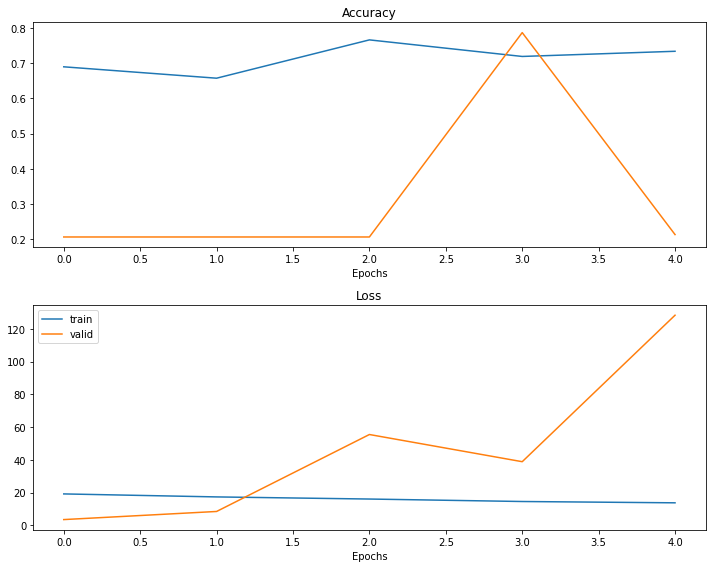

In [20]:
plot_charts(input_train_accs, input_train_losses, input_valid_accs, input_valid_losses)

### 2.2 Add Feature Transform

In the following section, please implement the following:
- Complete the FeatureTransform Class
- Update the FeatureTransformClassificationNN to include the Feature Transform

In [16]:
class FeatureTransform(nn.Module):
    def __init__(self):
        super(FeatureTransform, self).__init__()
        self.T_net = T_net(64)

    def forward(self, x):
        out = self.T_net(x)
        self.A = out
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)

In [17]:
class FullClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(FullClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):
        
        ##################################################
        # TO DO:
        # Create the forward function
        # You can copy and paste the code from class above and add the Feature Transform
        ##################################################

    def predict(self, x):
        return self.forward(x)[0]

In [18]:
full_model = FullClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(full_model.parameters(), lr=lr)
full_train_losses, full_valid_losses, full_train_accs, full_valid_accs = train(full_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

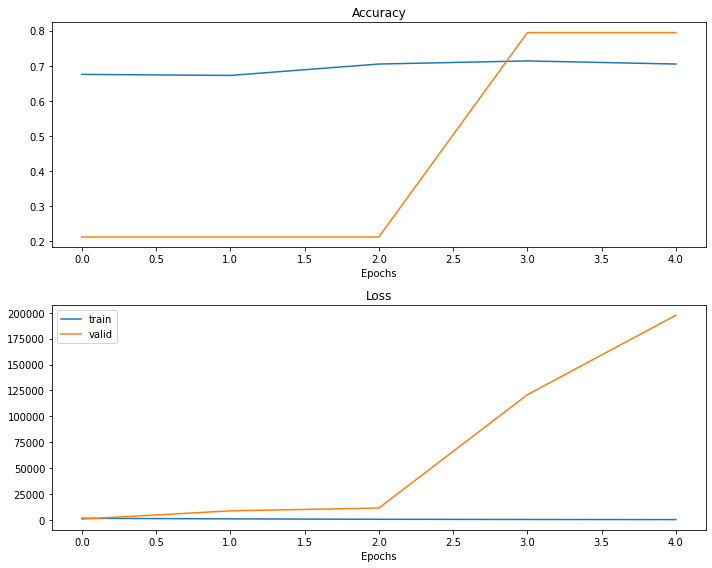

In [21]:
plot_charts(full_train_accs, full_train_losses, full_valid_accs, full_valid_losses)

### 2.4 Update the Task for Segmentation

In [19]:
class SegmentationNN(nn.Module):
    def __init__(self, num_features: int):
        super(SegmentationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()

        self.mlp_1 = SharedMLP([3, 64, 64])
        self.mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp_3 = SharedMLP([1088, 512, 256, 128])
        self.mlp_4 = SharedMLP([128, 128, num_features])
        
    def forward(self, x):
        out = self.input_transform(x)
        out = self.mlp_1(out)
        feat_out = self.feature_transform(out)
        global_feature = self.mlp_2(out)
        global_feature = F.max_pool1d(global_feature, x.size(2))
        global_feature = global_feature.expand(-1, -1, x.size(-1))
        out = torch.cat([out, global_feature], 1)
        out = self.mlp_3(out)
        out = self.mlp_4(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

# Remaining Items To-Do
- Improve the implementation of ModelNet2
- Finalize the Segmentation Network
- Dig into odd charts (why is validation loss increasing)